本代码用来展示训练好的模型的效果，期望的效果是能够输入对应的图象和分类结果，以及输出各个类别的概率

In [1]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from Resnet import ResNet, ResidualBlock
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
def predict_and_print(image_path, model, device, classes):
    """
    对输入图片进行预测，可视化图片（带坐标轴和预测标签），
    并将预测概率以文本形式输出。
    """
    img_pil = Image.open(image_path).convert('RGB')
    IMAGENET_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_STD = (0.229, 0.224, 0.225)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)  # 计算概率分布
    top_p, top_class = probs.topk(1, dim=1)
    predicted_class = classes[top_class.item()]
    probs_np = probs.cpu().numpy()[0]
    W, H = img_pil.size
    DISPLAY_ratio = 70
    figsize_w = W / DISPLAY_ratio
    figsize_h = H / DISPLAY_ratio
    plt.figure(figsize=(figsize_w, figsize_h), facecolor='none')
    plt.imshow(img_pil)
    plt.title(f"Predicted: {predicted_class}", fontsize=14)
    x_tick_interval = max(50, int(W / 5 / 50) * 50) 
    plt.xticks(np.arange(0, W + x_tick_interval, x_tick_interval))
    y_tick_interval = max(50, int(H / 5 / 50) * 50) 
    plt.yticks(np.arange(0, H + y_tick_interval, y_tick_interval))
    plt.xlim(0, W)
    plt.ylim(H, 0)
    plt.tight_layout()
    plt.show()
    text_output = f"Predicted Class: {predicted_class}\n"
    text_output += f"Class Probabilities:\n"
    for i, class_name in enumerate(classes):
        prob_val = probs_np[i]
        bar = '█' * int(prob_val * 20) 
        text_output += f"  {class_name:<11}: {prob_val:.4f}  |{bar}\n"
    print(text_output)
    return predicted_class, probs_np

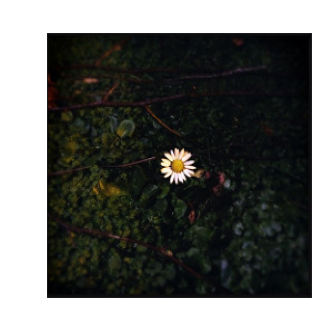

Predicted Class: daisy
Class Probabilities:
  daisy      : 0.9999  |███████████████████
  dandelion  : 0.0001  |
  roses      : 0.0000  |
  sunflowers : 0.0000  |
  tulips     : 0.0000  |



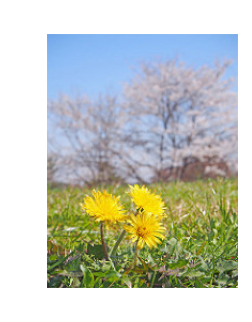

Predicted Class: dandelion
Class Probabilities:
  daisy      : 0.0008  |
  dandelion  : 0.9539  |███████████████████
  roses      : 0.0001  |
  sunflowers : 0.0338  |
  tulips     : 0.0113  |



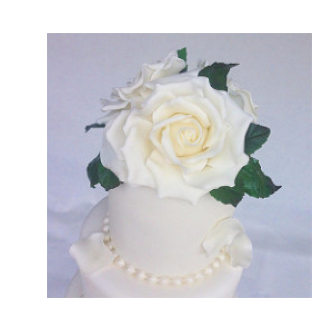

Predicted Class: roses
Class Probabilities:
  daisy      : 0.0675  |█
  dandelion  : 0.0385  |
  roses      : 0.7949  |███████████████
  sunflowers : 0.0016  |
  tulips     : 0.0975  |█



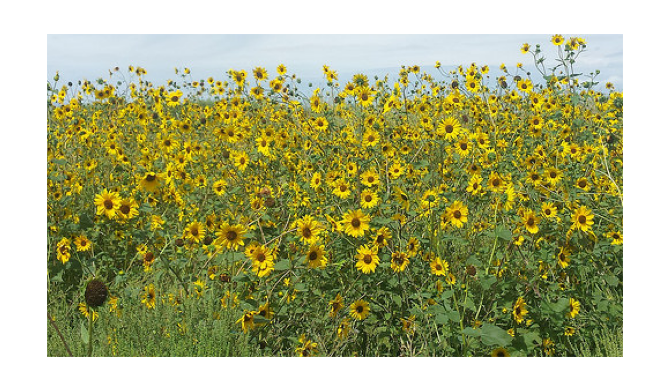

Predicted Class: sunflowers
Class Probabilities:
  daisy      : 0.0000  |
  dandelion  : 0.0001  |
  roses      : 0.0001  |
  sunflowers : 0.9997  |███████████████████
  tulips     : 0.0001  |



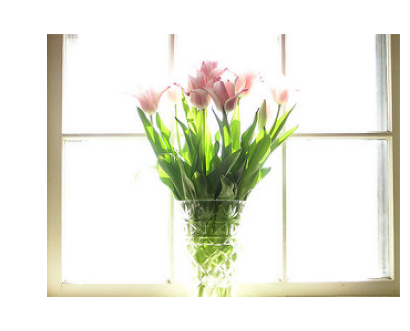

Predicted Class: tulips
Class Probabilities:
  daisy      : 0.2995  |█████
  dandelion  : 0.2015  |████
  roses      : 0.0633  |█
  sunflowers : 0.0036  |
  tulips     : 0.4321  |████████



In [5]:
model_layers = [3, 4, 6, 3]
num_classes = 5
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
model_path = "Model/resnet_model.pth"
test_data_path = "Data/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, model_layers, num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
# 将test_data_path目录下的所有类别子目录下的图片进行预测并显示结果
for class_name in os.listdir(test_data_path):
    class_dir = os.path.join(test_data_path, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            predict_and_print(img_path, model, device, classes)